In [53]:
import os
import argparse
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.models import Sequential, Model
from keras import Input, Model, layers, regularizers, callbacks
from keras.optimizers.legacy import Adam
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split, KFold
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr
import utils_results as ut
from test_results_analysis import create_mlp_model, lgbm_pi_obj, lgbm_pi_eval

In [93]:
basin = 'NWP'
results_folder = 'test1_linreg_nc5_nv8_nd9' # 'test1_pi-lgbm_DSnc10_nv8_nd9'
years = np.arange(1980, 2021, 1)
n_folds = 3

In [94]:
# Set directories and paths to file
project_dir = '/Users/huripari/Documents/PhD/TCs_Genesis'
target_file = 'target_1970-2022_2.5x2.5.csv'
nc_string = results_folder.split('_')[2]
n_clusters = int(results_folder.split('nc')[1].split('_')[0])
if "A" in nc_string:
    cluster_data = f'{basin}_{n_clusters}clusters_anomaly'
if "DS" in nc_string:
    cluster_data = f'{basin}_{n_clusters}clusters_deseason'
    target_season = 'target_seasonality_1970-2022_2.5x2.5.csv'
else:
    cluster_data = f'{basin}_{n_clusters}clusters'
n_vars = int(results_folder.split('nv')[1].split('_')[0])
n_idxs = int(results_folder.split('nd')[1].split('_')[0])
model_kind = results_folder.split('_')[1]
experiment_filename = f'1970-2022_{n_clusters}clusters_{n_vars}vars_{n_idxs}idxs.csv'
sol_filename = f'{model_kind}_' + experiment_filename
predictor_file = 'predictors_' + experiment_filename
fs_dir = os.path.join(project_dir, 'FS_TCG')
output_dir = os.path.join(fs_dir, 'results', basin, results_folder)
sol_path = os.path.join(output_dir, sol_filename)
best_sol_path = os.path.join(output_dir, f'best_solution_{sol_filename}')
data_dir = os.path.join(fs_dir, 'data', cluster_data)
predictors_path = os.path.join(data_dir, predictor_file)
target_path = os.path.join(data_dir, target_file)
gpis_path = os.path.join(fs_dir, 'data', f'{basin}_2.5x2.5_gpis_time_series.csv')

In [95]:
# Load the predictors and the target in a DataFrame
predictors_df = pd.read_csv(predictors_path, index_col=0)
predictors_df.index = pd.to_datetime(predictors_df.index)
target_df = pd.read_csv(target_path, index_col=0)
target_df.index = pd.to_datetime(target_df.index)
if "DS" in nc_string:
    target_season_df = pd.read_csv(os.path.join(data_dir, target_season), index_col=0)
    target_season_df.index = pd.to_datetime(target_season_df.index)

In [97]:
# Load the gpis time series dataframe and select the target GPIs for physical information to pass to the network
gpis_df = pd.read_csv(gpis_path, index_col=0)
gpis_df.index = pd.to_datetime(gpis_df.index)
gpi_pi = gpis_df['ogpi']
# Load the solutions file in a DataFrame and the best solution found
sol_file_df = pd.read_csv(sol_path, sep=' ', header=0)
best_solution = pd.read_csv(best_sol_path, sep=',', header=None)
best_solution = best_solution.to_numpy().flatten()
# Select the variables from the best solutions
column_names = predictors_df.columns.tolist()
final_sequence = best_solution[len(column_names):2*len(column_names)]
sequence_length = best_solution[:len(column_names)]
feat_sel = best_solution[2*len(column_names):]
# Create dataset according to solution and list the labels of the selected variables
variable_selection = feat_sel.astype(int)
time_sequences = sequence_length.astype(int)
time_lags = final_sequence.astype(int)
label_selected_vars = []
dataset_opt = target_df.copy()
for c, col in enumerate(predictors_df.columns):
    if variable_selection[c] == 0 or time_sequences[c] == 0:
        continue
    for j in range(time_sequences[c]):
        dataset_opt[str(col) +'_lag'+ str(time_lags[c]+j)] = predictors_df[col].shift(time_lags[c]+j)
        label_selected_vars.append(str(col) +'_lag'+ str(time_lags[c]+j))

In [98]:
# Compone the dataset to train the model using all predictors possible
dataset_opt_noFS = target_df.copy()
for l in range(1):
    for var in predictors_df.columns:
        col_df = pd.DataFrame(predictors_df[var].shift(l).values, index=dataset_opt_noFS.index, columns=[f'{var}_lag{l}'])
        dataset_opt_noFS = pd.concat([dataset_opt_noFS, col_df], axis=1)

In [36]:
## Train MLPregressor with the best solution found ##
# Cross-Validation for train and test years
kfold = KFold(n_splits=n_folds)
Y_column = 'tcg' # Target variable
obs_indices = dataset_opt.index.year.isin(years)
obs_dataset = dataset_opt[obs_indices]
Y_test = obs_dataset[Y_column]
Y_pred_mlp = pd.DataFrame()
Y_pred_pi_mlp = pd.DataFrame()
Y_pred_mlp_noFS = pd.DataFrame()
Y_pred_pi_mlp_noFS = pd.DataFrame()
Y_pred_lgbm = pd.DataFrame()
Y_pred_pi_lgbm = pd.DataFrame()
Y_pred_lgbm_noFS = pd.DataFrame()
Y_pred_pi_lgbm_noFS = pd.DataFrame()

for n_fold, (train_index, test_index) in enumerate(kfold.split(years)):

    # Set the indices for the training and test datasets
    train_years = years[train_index]
    test_years = years[test_index]
    # Split the optimized dataset
    train_indices = dataset_opt.index.year.isin(train_years)
    test_indices = dataset_opt.index.year.isin(test_years)
    train_dataset = dataset_opt[train_indices]
    test_dataset = dataset_opt[test_indices]
    # Split the entire dataset 
    train_indices_noFS = dataset_opt_noFS.index.year.isin(train_years)
    test_indices_noFS = dataset_opt_noFS.index.year.isin(test_years)
    train_dataset_noFS = dataset_opt_noFS[train_indices_noFS]
    test_dataset_noFS = dataset_opt_noFS[test_indices_noFS]
    # Split the gpis dataset
    gpi_pi_train = gpi_pi[train_indices]
    gpi_pi_test = gpi_pi[test_indices]

    # Standardize the optimized dataset
    X_train = train_dataset[train_dataset.columns.drop([Y_column])]
    Y_train = train_dataset[Y_column]
    X_test_fold = test_dataset[test_dataset.columns.drop([Y_column])]
    Y_test_fold = test_dataset[Y_column]
    scaler = preprocessing.MinMaxScaler()
    X_std_train = scaler.fit(X_train)
    X_std_train = scaler.transform(X_train)
    X_std_test = scaler.transform(X_test_fold)
    X_train = pd.DataFrame(X_std_train, columns=X_train.columns, index=X_train.index)
    X_test = pd.DataFrame(X_std_test, columns=X_test_fold.columns, index=X_test_fold.index)
    # Standardize the entire dataset
    X_train_noFS = train_dataset_noFS[train_dataset_noFS.columns.drop([Y_column])]
    X_test_fold_noFS = test_dataset_noFS[test_dataset_noFS.columns.drop([Y_column])]
    scaler_noFS = preprocessing.MinMaxScaler()
    X_std_train_noFS = scaler_noFS.fit(X_train_noFS)
    X_std_train_noFS = scaler_noFS.transform(X_train_noFS)
    X_std_test_noFS = scaler_noFS.transform(X_test_fold_noFS)
    X_train_noFS = pd.DataFrame(X_std_train_noFS, columns=X_train_noFS.columns, index=X_train_noFS.index)
    X_test_noFS = pd.DataFrame(X_std_test_noFS, columns=X_test_fold_noFS.columns, index=X_test_fold_noFS.index)

    # Split the training set in training and validation sets for all models and both datasets
    X_t, X_v, Y_t, Y_v, X_t_noFS, X_v_noFS, gpi_pi_t, gpi_pi_v = train_test_split(X_train, Y_train, X_train_noFS, gpi_pi_train, test_size=0.2, random_state=42)

    ## Define common training parameters and callbacks for the mlp ##
    n_neurons = 64
    epo = 100 # Number of epochs
    lr = 0.001 # Learning rate
    l2_reg = 0.001
    batch_size = 32
    callback = callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    ## MLPregressor with Selected Features ##
    # Build and compile the multi layer perceptron model for the optimized dataset
    n_predictors = len(X_train.columns)
    mlpreg = create_mlp_model(n_predictors, n_neurons, l2_reg, lr)
    # Prepare training and validation datasets
    train_data = tf.data.Dataset.from_tensor_slices((X_t.values, Y_t.values)).batch(batch_size)
    val_data = tf.data.Dataset.from_tensor_slices((X_v.values, Y_v.values)).batch(batch_size)
    # Train the model
    history = mlpreg.fit(train_data, validation_data=val_data, epochs=epo, callbacks=[callback], verbose=0)
    # Evaluate the model
    Y_pred_fold = mlpreg.predict(X_test, verbose=0)
    Y_pred_fold = pd.DataFrame(Y_pred_fold, index=Y_test_fold.index, columns=['tcg'])
    Y_pred_mlp = pd.concat([Y_pred_mlp, Y_pred_fold])
    loss = mlpreg.evaluate(X_test, Y_test_fold, verbose=0)

    ## MLPregressor with all Features ##
    # Build and compile the multi layer perceptron model for the entire dataset
    n_predictors_noFS = len(X_train_noFS.columns)
    mlpreg_noFS = create_mlp_model(n_predictors_noFS, n_neurons, l2_reg, lr)
    # Prepare training and validation datasets
    train_data = tf.data.Dataset.from_tensor_slices((X_t_noFS.values, Y_t.values)).batch(batch_size)
    val_data = tf.data.Dataset.from_tensor_slices((X_v_noFS.values, Y_v.values)).batch(batch_size)
    # Train the model
    history_noFS = mlpreg_noFS.fit(train_data, validation_data=val_data, epochs=epo, callbacks=[callback], verbose=0)
    # Evaluate the model
    Y_pred_fold_noFS = mlpreg_noFS.predict(X_test_noFS, verbose=0)
    Y_pred_fold_noFS = pd.DataFrame(Y_pred_fold_noFS, index=Y_test_fold.index, columns=['tcg'])
    Y_pred_mlp_noFS = pd.concat([Y_pred_mlp_noFS, Y_pred_fold_noFS])
    loss_noFS = mlpreg_noFS.evaluate(X_test_noFS, Y_test_fold, verbose=0)

    ## Plot the training and validation loss for the 2 models ##
    fig = ut.plot_train_val_loss(history.history['loss'], history.history['val_loss'], history_noFS.history['loss'], history_noFS.history['val_loss'], loss, loss_noFS)

    ## MLPregressor Physically Informed with Selected Features ##
    # Build and compile the multi layer perceptron model for the optimized dataset
    n_predictors = len(X_train.columns)
    mlpreg = create_mlp_model(n_predictors, n_neurons, l2_reg, lr, physical_informed=True)
    # Prepare training and validation datasets
    train_data = tf.data.Dataset.from_tensor_slices((X_t.values, (Y_t.values, gpi_pi_t.values))).batch(batch_size)
    val_data = tf.data.Dataset.from_tensor_slices((X_v.values, (Y_v.values, gpi_pi_v.values))).batch(batch_size)
    # Train model
    history = mlpreg.fit(train_data, validation_data=val_data, epochs=epo, callbacks=[callback], verbose=0)
    # Evaluate the model
    Y_pred_fold = mlpreg.predict(X_test, verbose=0)
    Y_pred_fold = pd.DataFrame(Y_pred_fold, index=Y_test_fold.index, columns=['tcg'])
    Y_pred_pi_mlp = pd.concat([Y_pred_pi_mlp, Y_pred_fold])
    loss = mlpreg.evaluate(X_test, (Y_test_fold, gpi_pi_test), verbose=0)

    ## MLPregressor Physically Informed with all Features ##
    # Build, compile and train the multi layer perceptron model for the entire dataset
    n_predictors_noFS = len(X_train_noFS.columns)
    mlpreg_noFS = create_mlp_model(n_predictors_noFS, n_neurons, l2_reg, lr, physical_informed=True)
    # Prepare training and validation datasets
    train_data = tf.data.Dataset.from_tensor_slices((X_t_noFS.values, (Y_t.values, gpi_pi_t.values))).batch(batch_size)
    val_data = tf.data.Dataset.from_tensor_slices((X_v_noFS.values, (Y_v.values, gpi_pi_v.values))).batch(batch_size)
    # Train model 
    history_noFS = mlpreg_noFS.fit(train_data, validation_data=val_data, epochs=epo, callbacks=[callback], verbose=0)
    # Evaluate the model
    Y_pred_fold_noFS = mlpreg_noFS.predict(X_test_noFS, verbose=0)
    Y_pred_fold_noFS = pd.DataFrame(Y_pred_fold_noFS, index=Y_test_fold.index, columns=['tcg'])
    Y_pred_pi_mlp_noFS = pd.concat([Y_pred_pi_mlp_noFS, Y_pred_fold_noFS])
    loss_noFS = mlpreg_noFS.evaluate(X_test_noFS, (Y_test_fold, gpi_pi_test), verbose=0)

    ## Plot the training and validation loss for the 2 models ##
    fig = ut.plot_train_val_loss(history.history['loss'], history.history['val_loss'], history_noFS.history['loss'], history_noFS.history['val_loss'], loss, loss_noFS)

    ## Define common training parameters and callbacks for the lgbm ##
    n_est = 100 # Number of estimators
    lr = 0.01 # Learning rate
    max_d = 3 # Maximum depth
    stop_rounds = 10 # Early stopping rounds

    ## LightGBM with Selected Features ##
    # Build, compile and train the lightgbm regressor for the optimized dataset
    lgbm = LGBMRegressor(n_estimators=n_est, learning_rate=lr, max_depth=max_d, objective='regression', verbosity=-1, early_stopping_rounds=stop_rounds)
    lgbm.fit(X_t, Y_t, eval_set=[(X_t, Y_t), (X_v, Y_v)], eval_names=['train', 'val'], eval_metric='l2')
    # Predictions on the test set
    Y_pred_fold_lgbm = lgbm.predict(X_test)
    Y_pred_fold_lgbm = pd.DataFrame(Y_pred_fold_lgbm, index=Y_test_fold.index, columns=['tcg'])
    Y_pred_lgbm = pd.concat([Y_pred_lgbm, Y_pred_fold_lgbm])
    # Evaluate the model for the optimized dataset
    loss_lgbm = mean_squared_error(Y_test_fold, Y_pred_fold_lgbm)

    ## LightGBM with all Features ##
    # Build, compile and train the lightgbm regressor for the entire dataset
    lgbm_noFS = LGBMRegressor(n_estimators=n_est, learning_rate=lr, max_depth=max_d, objective='regression', verbosity=-1, early_stopping_rounds=stop_rounds)
    lgbm_noFS.fit(X_t_noFS, Y_t, eval_set=[(X_t_noFS, Y_t), (X_v_noFS, Y_v)], eval_names=['train', 'val'], eval_metric='l2')
    # Predictions on the test set
    Y_pred_fold_lgbm_noFS = lgbm_noFS.predict(X_test_noFS)
    Y_pred_fold_lgbm_noFS = pd.DataFrame(Y_pred_fold_lgbm_noFS, index=Y_test_fold.index, columns=['tcg'])
    Y_pred_lgbm_noFS = pd.concat([Y_pred_lgbm_noFS, Y_pred_fold_lgbm_noFS])
    # Evaluate the model for the entire dataset
    loss_lgbm_noFS = mean_squared_error(Y_test_fold, Y_pred_fold_lgbm_noFS)

    ## Plot the training and validation loss for the 2 models ##
    fig = ut.plot_train_val_loss(lgbm.evals_result_['train']['l2'], lgbm.evals_result_['val']['l2'],
                                lgbm_noFS.evals_result_['train']['l2'], lgbm_noFS.evals_result_['val']['l2'], loss_lgbm, loss_lgbm_noFS)

    ## LightGBM Physically Informed with Selected Features ##
    def lgbm_custom_obj(y_true, y_pred):
        gpi = gpi_pi_t
        return lgbm_pi_obj(y_true, y_pred, gpi)
    def lgbm_custom_eval(y_true, y_pred):
        if len(y_true) > 100:
            gpi = gpi_pi_t
        else:
            gpi = gpi_pi_v
        return lgbm_pi_eval(y_true, y_pred, gpi)
    # Build, compile and train the lightgbm regressor for the optimized dataset
    lgbm = LGBMRegressor(n_estimators=n_est, learning_rate=lr, max_depth=max_d, objective=lgbm_custom_obj, verbosity=-1, early_stopping_rounds=stop_rounds)
    lgbm.fit(X_t, Y_t, eval_set=[(X_t, Y_t), (X_v, Y_v)], eval_names=['train', 'val'], eval_metric=lgbm_custom_eval)
    # Predictions on the test set
    Y_pred_fold_lgbm = lgbm.predict(X_test)
    Y_pred_fold_lgbm = pd.DataFrame(Y_pred_fold_lgbm, index=Y_test_fold.index, columns=['tcg'])
    Y_pred_pi_lgbm = pd.concat([Y_pred_pi_lgbm, Y_pred_fold_lgbm])
    # Evaluate the model for the optimized dataset
    loss_lgbm = lgbm_pi_eval(Y_test_fold, Y_pred_fold_lgbm, gpi_pi_test)[1]

    ## LightGBM Physically Informed with all Features ##
    # Build, compile and train the lightgbm regressor for the entire dataset
    lgbm_noFS = LGBMRegressor(n_estimators=n_est, learning_rate=lr, max_depth=max_d, objective=lgbm_custom_obj, verbosity=-1, early_stopping_rounds=stop_rounds)
    lgbm_noFS.fit(X_t_noFS, Y_t, eval_set=[(X_t_noFS, Y_t), (X_v_noFS, Y_v)], eval_names=['train', 'val'], eval_metric=lgbm_custom_eval)
    # Predictions on the test set
    Y_pred_fold_lgbm_noFS = lgbm_noFS.predict(X_test_noFS)
    Y_pred_fold_lgbm_noFS = pd.DataFrame(Y_pred_fold_lgbm_noFS, index=Y_test_fold.index, columns=['tcg'])
    Y_pred_pi_lgbm_noFS = pd.concat([Y_pred_pi_lgbm_noFS, Y_pred_fold_lgbm_noFS])
    # Evaluate the model for the entire dataset
    loss_lgbm_noFS = lgbm_pi_eval(Y_test_fold, Y_pred_fold_lgbm_noFS, gpi_pi_test)[1]
    
    ## Plot the training and validation loss for the 2 models ##
    fig = ut.plot_train_val_loss(lgbm.evals_result_['train']['pi-mse_eval'], lgbm.evals_result_['val']['pi-mse_eval'], 
                                lgbm_noFS.evals_result_['train']['pi-mse_eval'], lgbm_noFS.evals_result_['val']['pi-mse_eval'], loss_lgbm, loss_lgbm_noFS)

In [37]:
# If the models were trained with deseasonalized data, add back the seasonality to the predictions and observations
if "DS" in nc_string:
    Y_test = Y_test + target_season_df.loc[Y_test.index, 'seasonal']
    Y_pred_mlp['tcg'] = Y_pred_mlp['tcg'] + target_season_df.loc[Y_pred_mlp.index, 'seasonal']
    Y_pred_mlp_noFS['tcg'] = Y_pred_mlp_noFS['tcg'] + target_season_df.loc[Y_pred_mlp_noFS.index, 'seasonal']
    Y_pred_pi_mlp['tcg'] = Y_pred_pi_mlp['tcg'] + target_season_df.loc[Y_pred_pi_mlp.index, 'seasonal']
    Y_pred_pi_mlp_noFS['tcg'] = Y_pred_pi_mlp_noFS['tcg'] + target_season_df.loc[Y_pred_pi_mlp_noFS.index, 'seasonal']
    Y_pred_lgbm['tcg'] = Y_pred_lgbm['tcg'] + target_season_df.loc[Y_pred_lgbm.index, 'seasonal']
    Y_pred_lgbm_noFS['tcg'] = Y_pred_lgbm_noFS['tcg'] + target_season_df.loc[Y_pred_lgbm_noFS.index, 'seasonal']
    Y_pred_pi_lgbm['tcg'] = Y_pred_pi_lgbm['tcg'] + target_season_df.loc[Y_pred_pi_lgbm.index, 'seasonal']
    Y_pred_pi_lgbm_noFS['tcg'] = Y_pred_pi_lgbm_noFS['tcg'] + target_season_df.loc[Y_pred_pi_lgbm_noFS.index, 'seasonal']

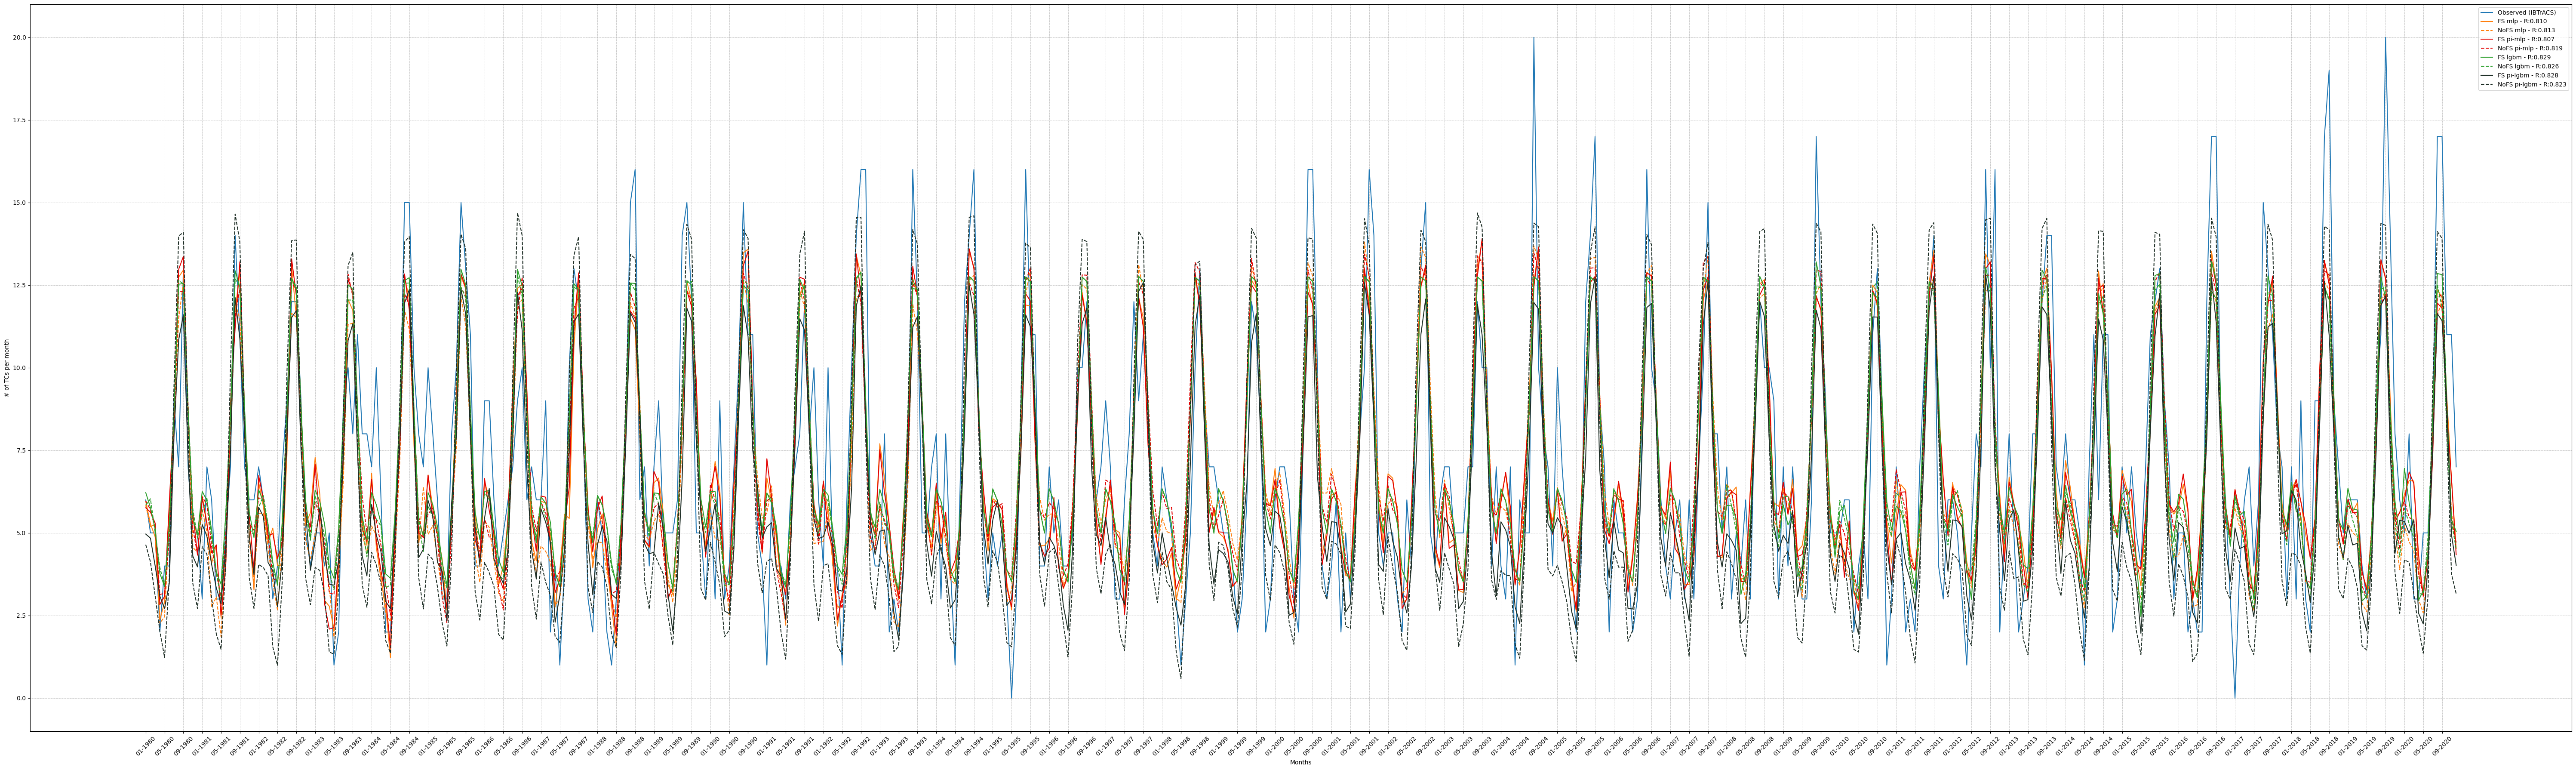

In [38]:
# Compare observations to predictions
r_mlp, _ = pearsonr(Y_test, Y_pred_mlp['tcg'])
r_mlp_noFS, _ = pearsonr(Y_test, Y_pred_mlp_noFS['tcg'])
r_pi_mlp, _ = pearsonr(Y_test, Y_pred_pi_mlp['tcg'])
r_pi_mlp_noFS, _ = pearsonr(Y_test, Y_pred_pi_mlp_noFS['tcg'])
r_lgbm, _ = pearsonr(Y_test, Y_pred_lgbm['tcg'])
r_lgbm_noFS, _ = pearsonr(Y_test, Y_pred_lgbm_noFS['tcg'])
r_pi_lgbm, _ = pearsonr(Y_test, Y_pred_pi_lgbm['tcg'])
r_pi_lgbm_noFS, _ = pearsonr(Y_test, Y_pred_pi_lgbm_noFS['tcg'])
xticks = pd.Series(Y_test.index).dt.strftime('%m-%Y').to_numpy()
plt.figure(figsize=(60, 18))
# observations
plt.plot(xticks, Y_test, label='Observed (IBTrACS)', color='#1f77b4')
# mlp predictions
plt.plot(xticks, Y_pred_mlp['tcg'], label=f'FS mlp - R:{r_mlp:.3f}', color='#ff7f0e')
plt.plot(xticks, Y_pred_mlp_noFS['tcg'], label=f'NoFS mlp - R:{r_mlp_noFS:.3f}', color='#ff7f0e', linestyle='--')
plt.plot(xticks, Y_pred_pi_mlp['tcg'], label=f'FS pi-mlp - R:{r_pi_mlp:.3f}', color='#e20000')
plt.plot(xticks, Y_pred_pi_mlp_noFS['tcg'], label=f'NoFS pi-mlp - R:{r_pi_mlp_noFS:.3f}', color='#e20000', linestyle='--')
# lgbm predictions
plt.plot(xticks, Y_pred_lgbm['tcg'], label=f'FS lgbm - R:{r_lgbm:.3f}', color='#2ca02c')
plt.plot(xticks, Y_pred_lgbm_noFS['tcg'], label=f'NoFS lgbm - R:{r_lgbm_noFS:.3f}', color='#2ca02c', linestyle='--')
plt.plot(xticks, Y_pred_pi_lgbm['tcg'], label=f'FS pi-lgbm - R:{r_pi_lgbm:.3f}', color='#1e2e26')
plt.plot(xticks, Y_pred_pi_lgbm_noFS['tcg'], label=f'NoFS pi-lgbm - R:{r_pi_lgbm_noFS:.3f}', color='#1e2e26', linestyle='--')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.xticks(ticks=np.arange(len(xticks))[::4], labels=xticks[::4], rotation=45)
plt.xlabel('Months')
plt.ylabel('# of TCs per month')
plt.legend()
plt.tight_layout()

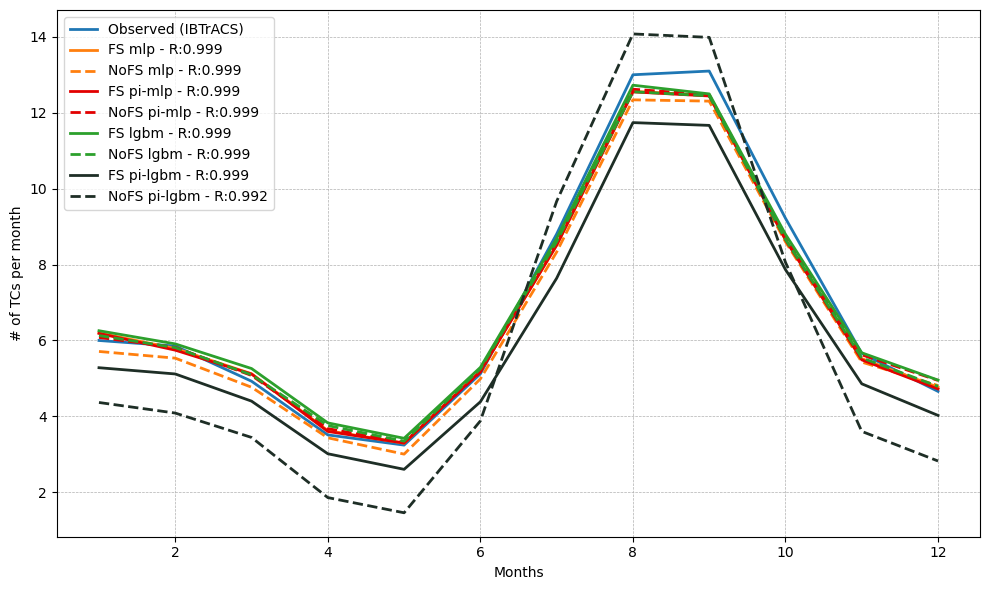

In [39]:
# Compare seasonal accumulated number of TCs
Y_test_seasonal = Y_test.groupby(Y_test.index.month).mean()
Y_pred_mlp_seasonal = Y_pred_mlp.groupby(Y_pred_mlp.index.month).mean()
Y_pred_mlp_noFS_seasonal = Y_pred_mlp_noFS.groupby(Y_pred_mlp_noFS.index.month).mean()
Y_pred_pi_mlp_seasonal = Y_pred_pi_mlp.groupby(Y_pred_pi_mlp.index.month).mean()
Y_pred_pi_mlp_noFS_seasonal = Y_pred_pi_mlp_noFS.groupby(Y_pred_pi_mlp_noFS.index.month).mean()
Y_pred_lgbm_seasonal = Y_pred_lgbm.groupby(Y_pred_lgbm.index.month).mean()
Y_pred_lgbm_noFS_seasonal = Y_pred_lgbm_noFS.groupby(Y_pred_lgbm_noFS.index.month).mean()
Y_pred_pi_lgbm_seasonal = Y_pred_pi_lgbm.groupby(Y_pred_pi_lgbm.index.month).mean()
Y_pred_pi_lgbm_noFS_seasonal = Y_pred_pi_lgbm_noFS.groupby(Y_pred_pi_lgbm_noFS.index.month).mean()
rS_mlp, _ = pearsonr(Y_test_seasonal, Y_pred_mlp_seasonal['tcg'])
rS_mlp_noFS, _ = pearsonr(Y_test_seasonal, Y_pred_mlp_noFS_seasonal['tcg'])
rS_pi_mlp, _ = pearsonr(Y_test_seasonal, Y_pred_pi_mlp_seasonal['tcg'])
rS_pi_mlp_noFS, _ = pearsonr(Y_test_seasonal, Y_pred_pi_mlp_noFS_seasonal['tcg'])
rS_lgbm, _ = pearsonr(Y_test_seasonal, Y_pred_lgbm_seasonal['tcg'])
rS_lgbm_noFS, _ = pearsonr(Y_test_seasonal, Y_pred_lgbm_noFS_seasonal['tcg'])
rS_pi_lgbm, _ = pearsonr(Y_test_seasonal, Y_pred_pi_lgbm_seasonal['tcg'])
rS_pi_lgbm_noFS, _ = pearsonr(Y_test_seasonal, Y_pred_pi_lgbm_noFS_seasonal['tcg'])
plt.figure(figsize=(10, 6))
# observations
plt.plot(Y_test_seasonal.index, Y_test_seasonal, label='Observed (IBTrACS)', color='#1f77b4', linewidth=2)
# mlp predictions
plt.plot(Y_pred_mlp_seasonal.index, Y_pred_mlp_seasonal['tcg'], label=f'FS mlp - R:{rS_mlp:.3f}', color='#ff7f0e', linewidth=2)
plt.plot(Y_pred_mlp_noFS_seasonal.index, Y_pred_mlp_noFS_seasonal['tcg'], label=f'NoFS mlp - R:{rS_mlp_noFS:.3f}', color='#ff7f0e', linestyle='--', linewidth=2)
plt.plot(Y_pred_pi_mlp_seasonal.index, Y_pred_pi_mlp_seasonal['tcg'], label=f'FS pi-mlp - R:{rS_pi_mlp:.3f}', color='#e20000', linewidth=2)
plt.plot(Y_pred_pi_mlp_noFS_seasonal.index, Y_pred_pi_mlp_noFS_seasonal['tcg'], label=f'NoFS pi-mlp - R:{rS_pi_mlp_noFS:.3f}', color='#e20000', linestyle='--', linewidth=2)
# lgbm predictions
plt.plot(Y_pred_lgbm_seasonal.index, Y_pred_lgbm_seasonal['tcg'], label=f'FS lgbm - R:{rS_lgbm:.3f}', color='#2ca02c', linewidth=2)
plt.plot(Y_pred_lgbm_noFS_seasonal.index, Y_pred_lgbm_noFS_seasonal['tcg'], label=f'NoFS lgbm - R:{rS_lgbm_noFS:.3f}', color='#2ca02c', linestyle='--', linewidth=2)
plt.plot(Y_pred_pi_lgbm_seasonal.index, Y_pred_pi_lgbm_seasonal['tcg'], label=f'FS pi-lgbm - R:{rS_pi_lgbm:.3f}', color='#1e2e26', linewidth=2)
plt.plot(Y_pred_pi_lgbm_noFS_seasonal.index, Y_pred_pi_lgbm_noFS_seasonal['tcg'], label=f'NoFS pi-lgbm - R:{rS_pi_lgbm_noFS:.3f}', color='#1e2e26', linestyle='--', linewidth=2)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.xlabel('Months')
plt.ylabel('# of TCs per month')
plt.legend()
plt.tight_layout()

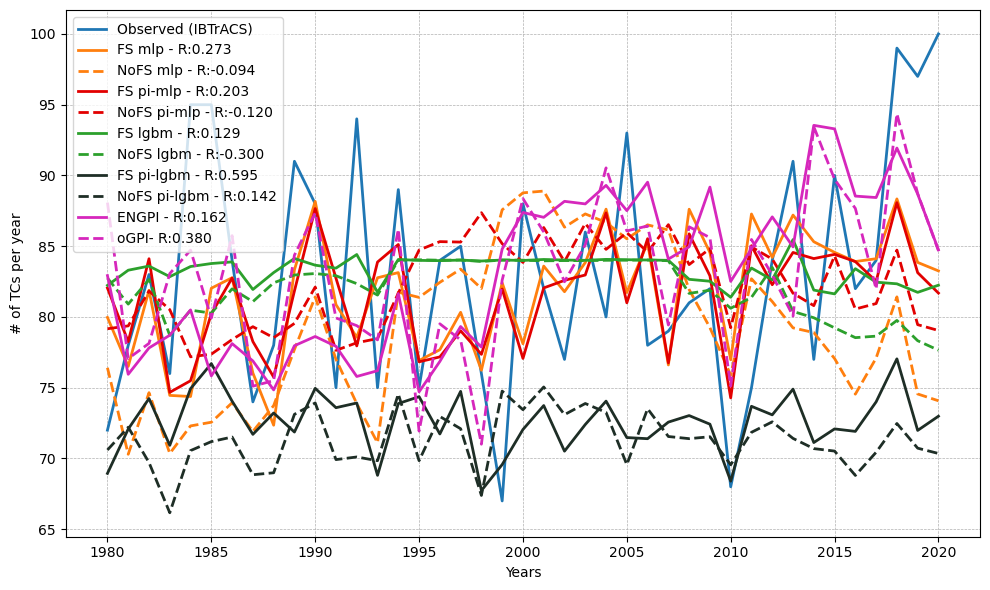

In [40]:
# Compare annual accumulated number of TCs
Y_test_annual = Y_test.resample('YE').sum()
Y_pred_mlp_annual = Y_pred_mlp.resample('YE').sum()
Y_pred_mlp_noFS_annual = Y_pred_mlp_noFS.resample('YE').sum()
Y_pred_pi_mlp_annual = Y_pred_pi_mlp.resample('YE').sum()
Y_pred_pi_mlp_noFS_annual = Y_pred_pi_mlp_noFS.resample('YE').sum()
Y_pred_lgbm_annual = Y_pred_lgbm.resample('YE').sum()
Y_pred_lgbm_noFS_annual = Y_pred_lgbm_noFS.resample('YE').sum()
Y_pred_pi_lgbm_annual = Y_pred_pi_lgbm.resample('YE').sum()
Y_pred_pi_lgbm_noFS_annual = Y_pred_pi_lgbm_noFS.resample('YE').sum()
gpi_indices = gpis_df.index.year.isin(years)
engpi_test_annual = gpis_df.loc[gpi_indices, 'engpi'].resample('YE').sum()
ogpi_test_annual = gpis_df.loc[gpi_indices, 'ogpi'].resample('YE').sum()
rY_mlp, _ = pearsonr(Y_test_annual, Y_pred_mlp_annual['tcg'])
rY_mlp_noFS, _ = pearsonr(Y_test_annual, Y_pred_mlp_noFS_annual['tcg'])
rY_pi_mlp, _ = pearsonr(Y_test_annual, Y_pred_pi_mlp_annual['tcg'])
rY_pi_mlp_noFS, _ = pearsonr(Y_test_annual, Y_pred_pi_mlp_noFS_annual['tcg'])
rY_lgbm, _ = pearsonr(Y_test_annual, Y_pred_lgbm_annual['tcg'])
rY_lgbm_noFS, _ = pearsonr(Y_test_annual, Y_pred_lgbm_noFS_annual['tcg'])
rY_pi_lgbm, _ = pearsonr(Y_test_annual, Y_pred_pi_lgbm_annual['tcg'])
rY_pi_lgbm_noFS, _ = pearsonr(Y_test_annual, Y_pred_pi_lgbm_noFS_annual['tcg'])
rY_engpi, _ = pearsonr(Y_test_annual, engpi_test_annual)
rY_ogpi, _ = pearsonr(Y_test_annual, ogpi_test_annual)
plt.figure(figsize=(10, 6))
# observations
plt.plot(Y_test_annual.index.year, Y_test_annual, label='Observed (IBTrACS)', color='#1f77b4', linewidth=2)
# mlp predictions
plt.plot(Y_pred_mlp_annual.index.year, Y_pred_mlp_annual['tcg'], label=f'FS mlp - R:{rY_mlp:.3f}', color='#ff7f0e', linewidth=2)
plt.plot(Y_pred_mlp_noFS_annual.index.year, Y_pred_mlp_noFS_annual['tcg'], label=f'NoFS mlp - R:{rY_mlp_noFS:.3f}', color='#ff7f0e', linestyle='--', linewidth=2)
plt.plot(Y_pred_pi_mlp_annual.index.year, Y_pred_pi_mlp_annual['tcg'], label=f'FS pi-mlp - R:{rY_pi_mlp:.3f}', color='#e20000', linewidth=2)
plt.plot(Y_pred_pi_mlp_noFS_annual.index.year, Y_pred_pi_mlp_noFS_annual['tcg'], label=f'NoFS pi-mlp - R:{rY_pi_mlp_noFS:.3f}', color='#e20000', linestyle='--', linewidth=2)
# lgbm predictions
plt.plot(Y_pred_lgbm_annual.index.year, Y_pred_lgbm_annual['tcg'], label=f'FS lgbm - R:{rY_lgbm:.3f}', color='#2ca02c', linewidth=2)
plt.plot(Y_pred_lgbm_noFS_annual.index.year, Y_pred_lgbm_noFS_annual['tcg'], label=f'NoFS lgbm - R:{rY_lgbm_noFS:.3f}', color='#2ca02c', linestyle='--', linewidth=2)
plt.plot(Y_pred_pi_lgbm_annual.index.year, Y_pred_pi_lgbm_annual['tcg'], label=f'FS pi-lgbm - R:{rY_pi_lgbm:.3f}', color='#1e2e26', linewidth=2)
plt.plot(Y_pred_pi_lgbm_noFS_annual.index.year, Y_pred_pi_lgbm_noFS_annual['tcg'], label=f'NoFS pi-lgbm - R:{rY_pi_lgbm_noFS:.3f}', color='#1e2e26', linestyle='--', linewidth=2)
# genesis potential indeces
plt.plot(engpi_test_annual.index.year, engpi_test_annual, label=f'ENGPI - R:{rY_engpi:.3f}', color='#d627bc', linewidth=2)
plt.plot(ogpi_test_annual.index.year, ogpi_test_annual, label=f'oGPI- R:{rY_ogpi:.3f}', color='#d627bc', linestyle='--', linewidth=2)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.xlabel('Years')
plt.ylabel('# of TCs per year')
plt.legend()
plt.tight_layout()